In [1]:
import numpy as np
import pandas as pd
from math import ceil
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import time
import sys

from libraries import get_torch_data, GRU_model

data_path = "data"

In [2]:
train_data = get_torch_data.get_train_data(data_path=data_path)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
model = GRU_model.Model(colsample=.5, dense1_size=400, GRU_size=200, dense2_size=200, dense3_size=150,
        dense4_size=100, dense5_size=40, features=train_data.features, seed=24338)
model = model.to(device)

In [5]:
learning_rate = .001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
trial = GRU_model.TrainTrial(batch_size=3000, max_n_epochs=200, patience=7,
    min_validation_rate=.05, train_data=train_data, seed=35375)

In [7]:
model = trial.train(device=device, model=model, optimizer=optimizer,
    objective_function=criterion, validation_metric=roc_auc_score)

Epoch 10:
	triggers: 0
	best score: 0.9414275639985101
	9.62 seconds per epoch on average.
Epoch 20:
	triggers: 0
	best score: 0.9454085484914962
	9.37 seconds per epoch on average.
Epoch 30:
	triggers: 2
	best score: 0.9494993207304184
	9.23 seconds per epoch on average.
Epoch 40:
	triggers: 0
	best score: 0.9536185502225053
	9.04 seconds per epoch on average.
Epoch 50:
	triggers: 0
	best score: 0.9565967954101987
	9.35 seconds per epoch on average.
Epoch 60:
	triggers: 0
	best score: 0.9585738167676198
	9.42 seconds per epoch on average.
Epoch 70:
	triggers: 2
	best score: 0.9605403981860101
	8.21 seconds per epoch on average.
Epoch 80:
	triggers: 2
	best score: 0.9617588401025673
	8.47 seconds per epoch on average.
Epoch 90:
	triggers: 2
	best score: 0.9633985840748497
	8.71 seconds per epoch on average.
Early stopping.


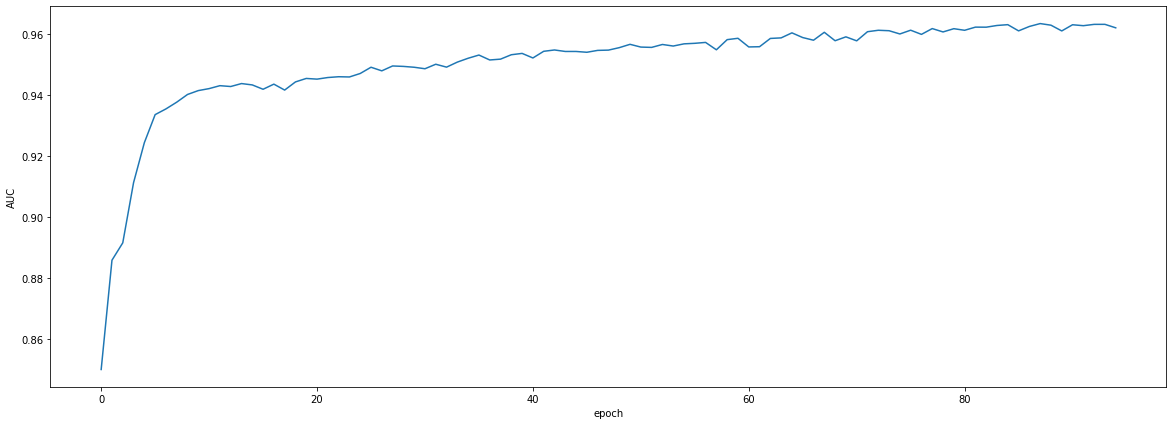

In [8]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(trial.validation_scores)
ax.set_xlabel('epoch')
ax.set_ylabel('AUC')
plt.show()

In [9]:
test_data = get_torch_data.get_test_data(data_path=data_path)

In [10]:
X = test_data.X.float().to(device)
y = test_data.y.float().to(device)
model.eval()
pred = model(X).detach().numpy()
y_true = y.detach().numpy()

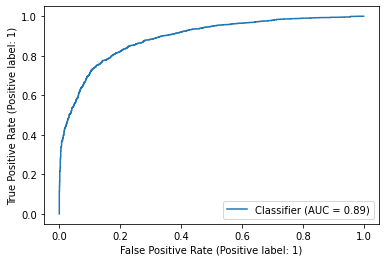

In [14]:
RocCurveDisplay.from_predictions(y_true, pred)
plt.show()

In [15]:
torch.save(model.state_dict(), 'model.pth')